In [5]:
# requirements, uncomment if needed

# !pip install faker
# !pip install yfinance

In [6]:
class settings:
    DATA_DIR = 'data'
    SEED = 42

In [7]:
from faker import Faker
import yfinance as yf
from datetime import datetime, timedelta
import json
import os

In [8]:
class FakeDataGenerator:
    def __init__(self, seed=settings.SEED):
        self.faker = Faker('id_ID')
        Faker.seed(seed)

    def generate_users(self, num_records=50):
        """
        nik           : Nomor Induk Kependudukan
        nama          : Nama Lengkap
        email         : Alamat Email
        telepon       : Nomor Telepon
        password      : Kata Sandi
        nomor_rekening: Nomor Rekening
        kyc_status    : Status KYC
        saldo         : Saldo
        """
        users = []
        for _ in range(num_records):
            user = {
                'nik': self.faker.ssn(),     
                'nama': self.faker.name().split(',')[0],
                'email': self.faker.email(),
                'telepon': self.faker.phone_number(),
                'password': self.faker.password(),
                'nomor_rekening': self.faker.bban(),
                'kyc_status': self.faker.random_element(elements=('verified', 'unverified')),
                'saldo': self.faker.random_int(min=100000, max=10000000),
            }
            users.append(user)
        return users

    def generate_moderators(self, num_records=20):
        """
        username: Nama Pengguna
        password: Kata Sandi
        """
        moderators = []
        for _ in range(num_records):
            moderator = {
                'username': self.faker.user_name(),
                'password': self.faker.password(),
            }
            moderators.append(moderator)
        return moderators

    def generate_stock_daily_price(self, num_records=100):
        """
        ticker: Kode Saham Indonesia
        open: Harga Pembukaan
        close: Harga Penutupan
        highest: Harga Tertinggi
        lowest: Harga Terendah
        date: Tanggal (datetime mariadb)
        """
        stock_data = []
        
        tickers = ['BBCA.JK', 'TLKM.JK', 'UNVR.JK', 'BMRI.JK', 'ASII.JK',
                   'BRPT.JK', 'PGAS.JK', 'GGRM.JK', 'HMSP.JK', 'ITMG.JK',
                   'JPFA.JK', 'MDKA.JK', 'PTBA.JK', 'SMGR.JK', 'TINS.JK']
        for ticker in tickers:
            # Get historical data for the ticker
            data = yf.download(ticker, period='1y', interval='1d')
            data.reset_index(inplace=True)
            data['ticker'] = ticker

            data = data[['ticker', 'Date', 'Open', 'Close', 'High', 'Low']]
            data.columns = ['ticker', 'date',
                            'open', 'close', 'highest', 'lowest']

            data['date'] = data['date'].dt.strftime('%Y-%m-%d')

            stock_data.extend(data.to_dict(orient='records'))
        return stock_data

    def generate_live_stock_price_change(self, num_records=1000, tickers=[]):
        """
        ticker   : Kode Saham Indonesia
        price    : Harga Perubahan (monoton naik)
        timestamp: Waktu mulai perubahan (datetime mariadb)
        """
        live_stock_price_change = []

        for ticker in tickers:
            # Inisialisasi data awal
            initial_price = self.faker.random_int(min=1000, max=10000)
            initial_time = self.faker.date_time_this_year()
            live_stock_price_change.append({
                'ticker': ticker,
                'price': round(initial_price, 2),
                'timestamp': initial_time.strftime('%Y-%m-%d %H:%M:%S')
            })

            current_price = initial_price
            current_time = initial_time

            # Generate perubahan harga monoton naik
            for _ in range(num_records // len(tickers) - 1):
                # Pastikan delta selalu positif (0.1% s.d. 3%)
                delta_pct = self.faker.random.uniform(0.001, 0.03)
                current_price *= (1 + delta_pct)
                current_price = round(current_price, 2)

                # Tambah waktu
                delta_seconds = self.faker.random_int(min=10, max=60)
                current_time += timedelta(seconds=delta_seconds)

                live_stock_price_change.append({
                    'ticker': ticker,
                    'price': current_price,
                    'timestamp': current_time.strftime('%Y-%m-%d %H:%M:%S')
                })

        return live_stock_price_change

    def generate_stock_ipo(self, num_records=20):
        """
        ticker: Kode Saham Indonesia
        harga_penawaran: Harga Penawaran
        status_ipo: Status IPO
        tanggal_ipo: Tanggal IPO (datetime mariadb)
        """
        # use ticker different from daily price
        tickers = [
            "ELIT.JK", "BAYU.JK", "BINA.JK", "BOLT.JK", "WIFI.JK",
            "DATA.JK", "VKTR.JK", "FORE.JK", "ISAT.JK", "EXCL.JK",

        ]
        stock_ipo = []
        for ticker in tickers:
            ipo = {
                'ticker': ticker,
                'harga_penawaran': self.faker.random_int(min=1000, max=10000),
                'status_ipo': self.faker.random_element(elements=('open', 'closed')),
                'tanggal_ipo': self.faker.date_between(start_date='-1y', end_date='today').strftime('%Y-%m-%d')
            }
            stock_ipo.append(ipo)
        return stock_ipo

    def generate_stocks(self, num_records=20, tickers=[]):
        """
        ticker: Kode Saham Indonesia
        nama_perusahaan: Nama Perusahaan
        sektor: Sektor Perusahaan
        profil: Profil Perusahaan
        tipe: Tipe Perusahaan
        """
        stocks = []
        for ticker in tickers:
            stock = yf.Ticker(ticker)
            info = stock.info
            name = info.get('longName', 'Unknown')
            sector = info.get('sector', 'Unknown')
            profile = info.get('longBusinessSummary', 'Unknown')
            tipe = info.get('quoteType', 'Unknown')
            stock_data = {
                'ticker': ticker,
                'nama_perusahaan': name,
                'sektor': sector,
                'profil': profile,
                'tipe': tipe
            }
            stocks.append(stock_data)
        return stocks

    def generate_posts(self, num_records=100):
        """
        post_id: ID Postingan (int)
        isi: Isi Postingan (text)
        """
        posts = []
        id_cnt = 1
        for _ in range(num_records):
            post = {
                'post_id': id_cnt,
                'isi': self.faker.text(max_nb_chars=200),
            }
            posts.append(post)
            id_cnt += 1
        return posts
    
    def generator_orders(self, num_records=100, tickers=[]):
        """
        id_order: ID Order (int)
        tipe_order: Tipe Order enum ('beli', 'jual')
        harga: Harga Order (int)
        jumlah_lembar: Jumlah Lembar (int)
        status: Status Order enum ('pending', 'partial', 'executed')
        """
        id_cnt = 1
        orders = []
        for _ in range(num_records):
            order = {
                'id_order': id_cnt,
                'tipe_order': self.faker.random_element(elements=('beli', 'jual')),
                'harga': self.faker.random_int(min=1000, max=10000),
                'jumlah_lembar': self.faker.random_int(min=1, max=100000),
                'status': self.faker.random_element(elements=('pending', 'partial', 'executed')),
            }
            orders.append(order)
            id_cnt += 1
        return orders

    def generate_predictions(self, num_records=50, id_posts=None, tickers=None):
        """
        Generate a list of stock price predictions.

        Parameters:
        - num_records (int): Number of prediction records to generate.
        - id_posts (List[int]): List of post IDs. Each will be used at most once.
        - tickers (List[str]): List of stock ticker symbols. Can be reused.

        Note:
        - Each id_post will be used at most once (no duplicates).
        - Tickers can be reused across predictions.

        Returns:
        - List[dict]: A list of prediction dictionaries.
        """
        if id_posts is None or tickers is None:
            raise ValueError("Both id_posts and tickers must be provided.")
        if not id_posts or not tickers:
            raise ValueError("id_posts and tickers must not be empty.")
        if num_records > len(id_posts):
            raise ValueError("num_records cannot be greater than the number of unique id_posts.")

        selected_posts = self.faker.random_elements(elements=id_posts, length=num_records, unique=True)
        predictions = []
        for id_post in selected_posts:
            prediction = {
                'id_post': id_post,
                'ticker': self.faker.random_element(elements=tickers),
                'price': self.faker.random_int(min=0, max=1_000_000),
                'durasi': self.faker.random_int(min=1, max=365),
            }
            predictions.append(prediction)
        return predictions

    
    def generate_user_posts(self, num_records=50, id_posts=[], id_users=[]):
        """
        id_post: ID Postingan (int) — unik
        id_user: ID Pengguna (int)

        id_user (one) -> id_post (many)
        Artinya: setiap post hanya boleh dimiliki oleh satu user
        """
        user_posts = []
        available_posts = id_posts.copy()
        
        max_records = min(num_records, len(available_posts))

        for _ in range(max_records):
            id_post = self.faker.random_element(elements=available_posts)
            id_user = self.faker.random_element(elements=id_users)
            
            user_posts.append({
                'id_post': id_post,
                'id_user': id_user,
            })

            available_posts.remove(id_post) 

        return user_posts
    
    def generate_user_comments(self, num_records=50, id_comments=[], id_users=[]):
        """
        id_comment: ID Komentar (int) — unik
        id_user   : ID Pengguna (int)

        id_user (one) -> id_comment (many)
        Artinya: satu komentar hanya dimiliki oleh satu user,
                tapi satu user bisa punya banyak komentar.
        """
        user_comments = []
        available_comments = id_comments.copy()

        max_records = min(num_records, len(available_comments))

        for _ in range(max_records):
            id_comment = self.faker.random_element(elements=available_comments)
            id_user = self.faker.random_element(elements=id_users)

            user_comments.append({
                'id_comment': id_comment,
                'id_user': id_user,
            })

            available_comments.remove(id_comment) 

        return user_comments
        
    
    def generate_monitoring_posts(self, num_records=50, id_posts=[], mod_uname=[]):
        """
        id_post: ID Postingan (int)
        moderator: Username
        approval_status: Status Persetujuan enum ('approved', 'rejected')
        timestamp: Waktu Persetujuan (datetime mariadb)        
        """
        monitoring_posts = []
        for _ in range(num_records):
            monitoring_post = {
                'id_post': self.faker.random_element(elements=id_posts),
                'moderator': self.faker.random_element(elements=mod_uname),
                'approval_status': self.faker.random_element(elements=('approved', 'rejected')),
                'timestamp': self.faker.date_time_this_year().strftime('%Y-%m-%d %H:%M:%S')
            }
            monitoring_posts.append(monitoring_post)
        return monitoring_posts
    
    def generate_post_tagging(self, num_records=50, id_posts=[], tickers=[]):
        """
        id_post: ID Postingan (int)
        ticker: Kode Saham Indonesia
        """
        post_tagging = []
        for _ in range(num_records):
            tagging = {
                'id_post': self.faker.random_element(elements=id_posts),
                'ticker': self.faker.random_element(elements=tickers),
            }
            post_tagging.append(tagging)
        return post_tagging
    
    def generate_post_comments(self, num_records=50, id_posts=[], id_comments=[]):
        """
        id_post: ID Postingan (int)
        id_comment: ID Komentar (int) — unik
        """

    def save_to_json(self, data) -> None:
        """
        Save the generated data to a JSON file.
        """
        for key, value in data.items():
            file_path = os.path.join(settings.DATA_DIR, f"{key}.json")
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(value, f, ensure_ascii=False, indent=4)

    def gen(self):
        db = {}
        db['Users'] = self.generate_users(50)
        db['Moderators'] = self.generate_moderators(20)
        db['Stock_Daily_Price'] = self.generate_stock_daily_price(100)
        daily_tickers = [item['ticker'] for item in db['Stock_Daily_Price']]
        db['Live_Stock_Price_Change'] = self.generate_live_stock_price_change(
            1000, daily_tickers)
        db['Stock_IPO'] = self.generate_stock_ipo(20)
        ipo_tickers = [item['ticker'] for item in db['Stock_IPO']]
        all_tickers = list(set(ipo_tickers + daily_tickers))
        db['Stocks'] = self.generate_stocks(len(all_tickers), all_tickers)
        db['Posts'] = self.generate_posts(100)
        db['Monitoring_Posts'] = None
        db['Predictions'] = self.generate_predictions(
            50, [item['post_id'] for item in db['Posts']], daily_tickers)

        self.save_to_json(db)
        return db


generator = FakeDataGenerator()
db = generator.gen()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

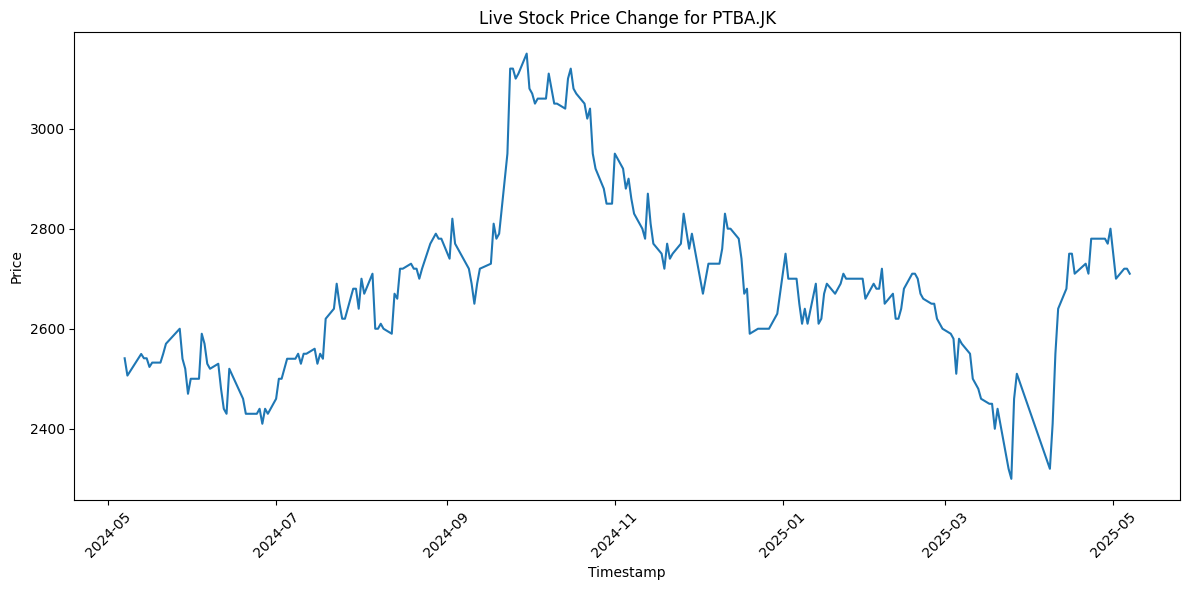

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_live_stock_price_change(data, ticker):
    # Filter data for the specified ticker
    ticker_data = [item for item in data if item['ticker'] == ticker]

    if not ticker_data:
        print(f"No data found for ticker '{ticker}'.")
        return

    # Convert to DataFrame
    df = pd.DataFrame(ticker_data)

    if 'date' not in df.columns:
        print(
            f"'date' column not found in data. Available columns: {df.columns.tolist()}")
        print("Sample data:", df.head())
        return

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='date', y='open')
    plt.title(f'Live Stock Price Change for {ticker}')
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_live_stock_price_change(db['Stock_Daily_Price'], 'PTBA.JK')